In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')
prior_orders = pd.read_csv('../input/order_products__prior.csv')
train_orders = pd.read_csv('../input/order_products__train.csv')
orders = pd.read_csv('../input/orders.csv')
products = pd.read_csv('../input/products.csv')

In [3]:
# Joining Train & prior orders together
merged_order_products = pd.merge(train_orders, prior_orders, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [4]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_detail = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_detail.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [5]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_detail, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [6]:
# Now merge the orders with the ordered products, combining on order_id, so we will have product descriptions alongside with order
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [7]:
# Aisle is easier than product as product details are too much information for the model
user_info = merged_orders[['user_id', 'order_number', 'order_dow', 'order_hour_of_day',
                           'days_since_prior_order', 'aisle']]

In [8]:
user_details = pd.get_dummies(user_info, prefix=None, columns=['aisle'])

In [9]:
# Couldn't use group on the user info as it is really big dataset & there are issues with memory allocation. we can try seggeregating  the data & then trying
#to group by user id.
#grouped_user = user_data.groupby('user_id').sum()

In [22]:
# Dividing the data into 3 parts to group by user_ID
user_data1 = user_details[user_details['user_id'] <= 70000]
user_data2 = user_details[(user_details['user_id'] <= 150000) & (user_details['user_id'] > 70000)]
user_data3 = user_details[user_details['user_id'] > 150000]

In [23]:
grouped_user1 = user_data1.groupby('user_id').sum()
grouped_user2 = user_data2.groupby('user_id').sum()
grouped_user3 = user_data3.groupby('user_id').sum()

In [24]:
# Go back to user_data and drop the aisle info before I group the other variables in different ways
user_data1_exclude_aisles = user_data1.iloc[:,:5]
user_data2_exclude_aisles = user_data2.iloc[:,:5]
user_data3_exclude_aisles = user_data3.iloc[:,:5]

In [25]:
user_data1_exclude_aisles.head()

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,1,2,8,NaN
1,1,1,2,8,NaN
2,1,1,2,8,NaN
3,1,1,2,8,NaN
4,1,1,2,8,NaN


In [26]:
grouped_by_user_data1 = user_data1_exclude_aisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0],
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
grouped_by_user_data2 = user_data2_exclude_aisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0],
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})
grouped_by_user_data3 = user_data3_exclude_aisles.groupby('user_id').agg({'order_number': 'max', 'order_dow': lambda x:x.value_counts().index[0],
                                            'order_hour_of_day': 'median', 'days_since_prior_order': 'mean'})

In [27]:
# get number of orders for each user and add to grouped_user dfs
grouped_user1.insert(1, 'num_orders', grouped_by_user_data1.order_number)

In [29]:
grouped_user1.insert(2, 'mean_days_since', grouped_by_user_data1.days_since_prior_order)
grouped_user1.insert(3, 'mode_order_dow', grouped_by_user_data1.order_dow)
grouped_user1.insert(4, 'median_order_hour', grouped_by_user_data1.order_hour_of_day)

In [32]:
# get number of orders for each user and add to grouped_user dfs
grouped_user2.insert(1, 'num_orders', grouped_by_user_data2.order_number)
grouped_user2.insert(2, 'mean_days_since', grouped_by_user_data2.days_since_prior_order)
grouped_user2.insert(3, 'mode_order_dow', grouped_by_user_data2.order_dow)
grouped_user2.insert(4, 'median_order_hour', grouped_by_user_data2.order_hour_of_day)


ValueError: cannot insert num_orders, already exists

In [33]:
grouped_user2.head()

,order_number,num_orders,mean_days_since,mode_order_dow,median_order_hour,order_dow,order_hour_of_day,days_since_prior_order,aisle_air fresheners candles,aisle_asian foods,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
70001,12916,40,9.254932,6,15.0,2788,9831,6099.0,0.0,0.0,...,10.0,1.0,0.0,0.0,0.0,0.0,1.0,16.0,0.0,8.0
70002,151,5,26.000000,6,12.0,134,590,1170.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
70003,13657,46,8.990654,1,15.0,1396,7324,4810.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,2.0
70004,10,3,24.000000,0,16.0,4,87,72.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70005,992,15,11.379310,0,9.0,264,1351,1320.0,0.0,0.0,...,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# get number of orders for each user and add to grouped_user dfs
grouped_user3.insert(1, 'num_orders', grouped_by_user_data3.order_number)
grouped_user3.insert(2, 'mean_days_since', grouped_by_user_data3.days_since_prior_order)
grouped_user3.insert(3, 'mode_order_dow', grouped_by_user_data3.order_dow)
grouped_user3.insert(4, 'median_order_hour', grouped_by_user_data3.order_hour_of_day)

In [30]:
grouped_user1.head()

,order_number,num_orders,mean_days_since,mode_order_dow,median_order_hour,order_dow,order_hour_of_day,days_since_prior_order,aisle_air fresheners candles,aisle_asian foods,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,464,11,19.200000,4,8.0,200,710,1248.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,2032,15,18.009390,1,10.0,422,2377,3836.0,0.0,3.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,528,12,11.487179,0,16.0,89,1439,896.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,52,5,15.357143,4,13.0,85,236,215.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,137,5,12.314286,0,16.0,60,681,431.0,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [35]:
grouped_user1.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user2.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)
grouped_user3.drop(columns=['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], inplace=True)

In [36]:
grouped_users = pd.concat([grouped_user1, grouped_user2, grouped_user3], axis=0)

In [37]:
grouped_users.head()

,num_orders,mean_days_since,mode_order_dow,median_order_hour,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,19.200000,4,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,15,18.009390,1,10.0,0.0,3.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,42.0
3,12,11.487179,0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,5,15.357143,4,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,12.314286,0,16.0,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_users = scaler.fit_transform(grouped_users)

In [39]:
from sklearn.cluster import KMeans
random_state = 12

'''The classical EM-style algorithm is “full”. The “elkan” variation is more efficient on data with well-defined clusters,
by using the triangle inequality. However it’s more memory intensive due to the allocation of an extra array of shape
(n_samples, n_clusters).'''

# Is having 20 separate market segments helpful?  Can I figure out what make them different and target that?

k_means_13 = KMeans(n_clusters=13, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_14 = KMeans(n_clusters=14, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_15 = KMeans(n_clusters=15, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_16 = KMeans(n_clusters=16, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_17 = KMeans(n_clusters=17, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_18 = KMeans(n_clusters=18, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_19 = KMeans(n_clusters=19, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_10 = KMeans(n_clusters=10, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_11 = KMeans(n_clusters=11, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_12 = KMeans(n_clusters=12, random_state=random_state, algorithm='full').fit(scaled_users)
k_means_20 = KMeans(n_clusters=20, random_state=random_state, algorithm='full').fit(scaled_users)

In [40]:
from sklearn.metrics import calinski_harabasz_score

k_list = [k_means_13, k_means_14, k_means_15, k_means_16,k_means_17, k_means_18, k_means_19, k_means_20]
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(grouped_users, labels))

Text(0.5, 0, 'K=')

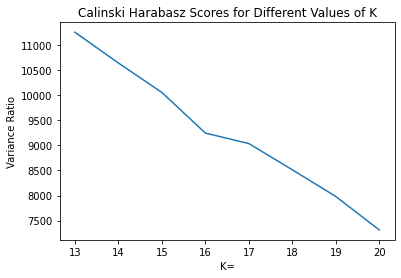

In [42]:
plt.plot([13, 14, 15, 16, 17, 18, 19, 20], CH_score)
plt.xticks([13,14,15,16,17,18,19,20])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')

In [43]:
# Looking at Within Cluster Sum of Squares

wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

Text(0.5, 0, 'K=')

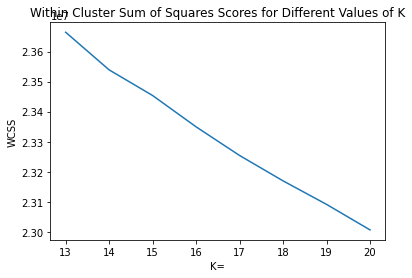

In [44]:
plt.plot([13, 14, 15, 16, 17, 18, 19, 20], wcss_score)
plt.xticks([13,14,15,16,17,18,19,20])
plt.title('Within Cluster Sum of Squares Scores for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')

In [45]:
# Add cluster assignment to the grouped_users dataframe
grouped_users['cluster'] = k_means_20.labels_

In [46]:
pickle.dump(grouped_users, open('../input/clustered_users.p', 'wb')) # creating grouped users with cluster info

In [47]:
grouped_users.cluster.value_counts()

7     71180
1     56887
5     37100
14    11516
4      8535
6      5131
19     4809
18     1885
13     1758
16     1370
3       901
17      885
9       835
2       827
0       692
15      569
12      499
10      468
11      206
8       156
Name: cluster, dtype: int64

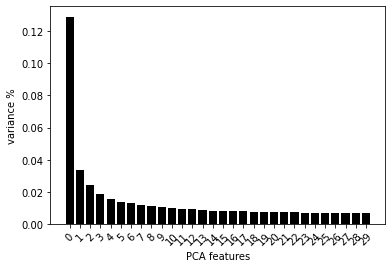

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components = 30)
principalComponents = pca.fit_transform(scaled_users)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.xticks(rotation = 45)

PCA_components = pd.DataFrame(principalComponents)

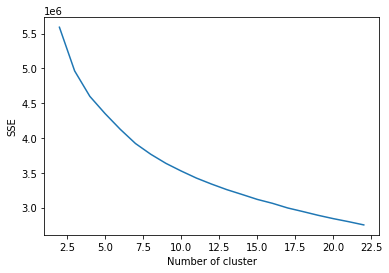

In [49]:
sse = {}
labels = {}
for k in range(2,23):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3,4,5,6,7,8,9]])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()